In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from src.utils.helpers import set_random_seed
set_random_seed()

# Data

## Data Loading

In [4]:
from src.data import download_data

In [5]:
download_data(force_download=False)

## Data Analysis and Cleaning

In [6]:
from src.data import load_characters, load_movies, load_movies_and_plots, load_plots
# load all tables
movies = load_movies()
characters = load_characters()
plots = load_plots()

In [7]:
show_amount = 2

print(f"Movie Metadata of shape {movies.shape}:")
display(movies.head(show_amount))

print(f"\nCharacter Metadata of shape {characters.shape}:")
display(characters.head(show_amount))

print(f"\nPlot Summaries of shape {plots.shape}:")
display(plots.head(show_amount))

Movie Metadata of shape (81741, 9):


,WikipediaId,FreebaseId,MovieName,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."



Character Metadata of shape (450669, 13):


,WikipediaId,FreebaseId,ReleaseDate,CharacterName,ActorDateOfBirth,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtRelease,FreebaseCharacterActorMapId,FreebaseCharId,FreebaseActorId
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4



Plot Summaries of shape (42303, 2):


,WikipediaId,PlotSummary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


Now we focus on identifying and handling missing values within the CMU Movie Summary dataset. We will inspect missing values in the `movies` and `characters` tables, visualize the distribution of missing data and drop the rows with missing information.

To understand where the data is incomplete, we will calculate the number of missing values for each column in the `movies` and `characters` tables. As we are not using `plots` in the current plan, we are not making any analysis related to them.

At first, let's analyse the `movies` table:

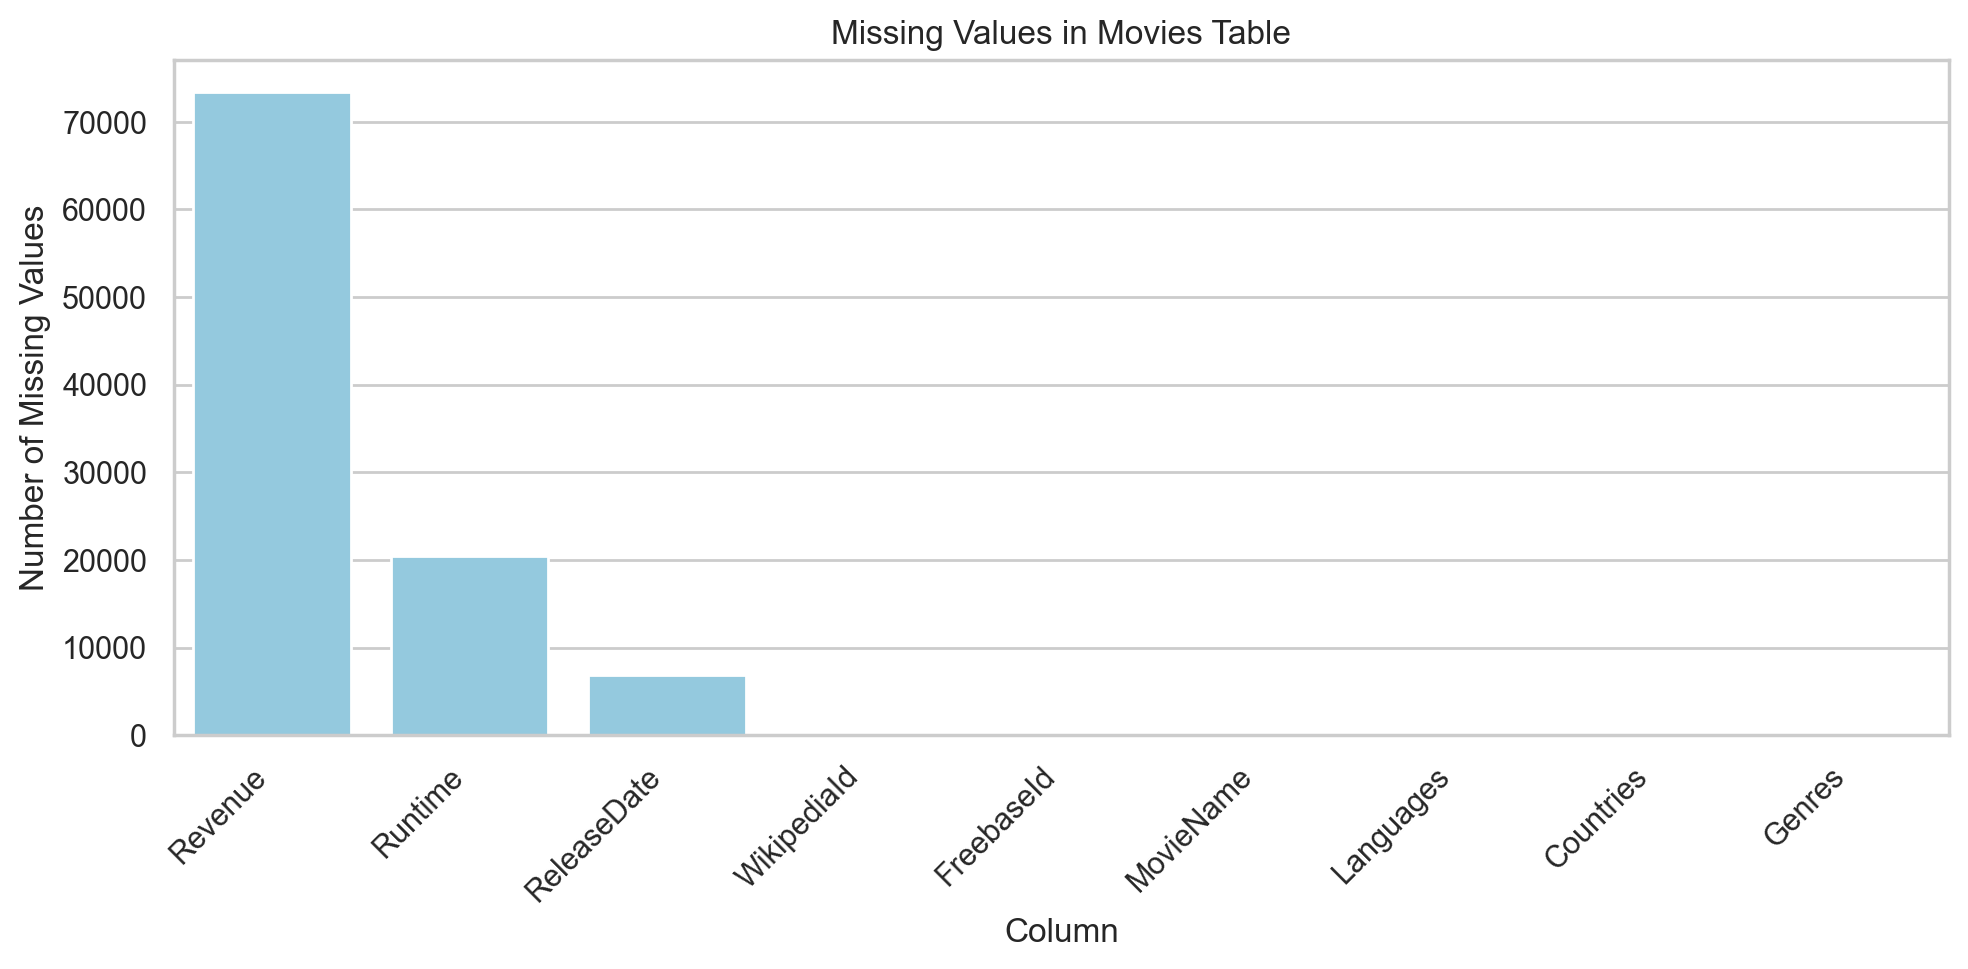

In [8]:
from src.utils.helpers import plot_nan_distribution

plot_nan_distribution(movies, table_name="Movies")

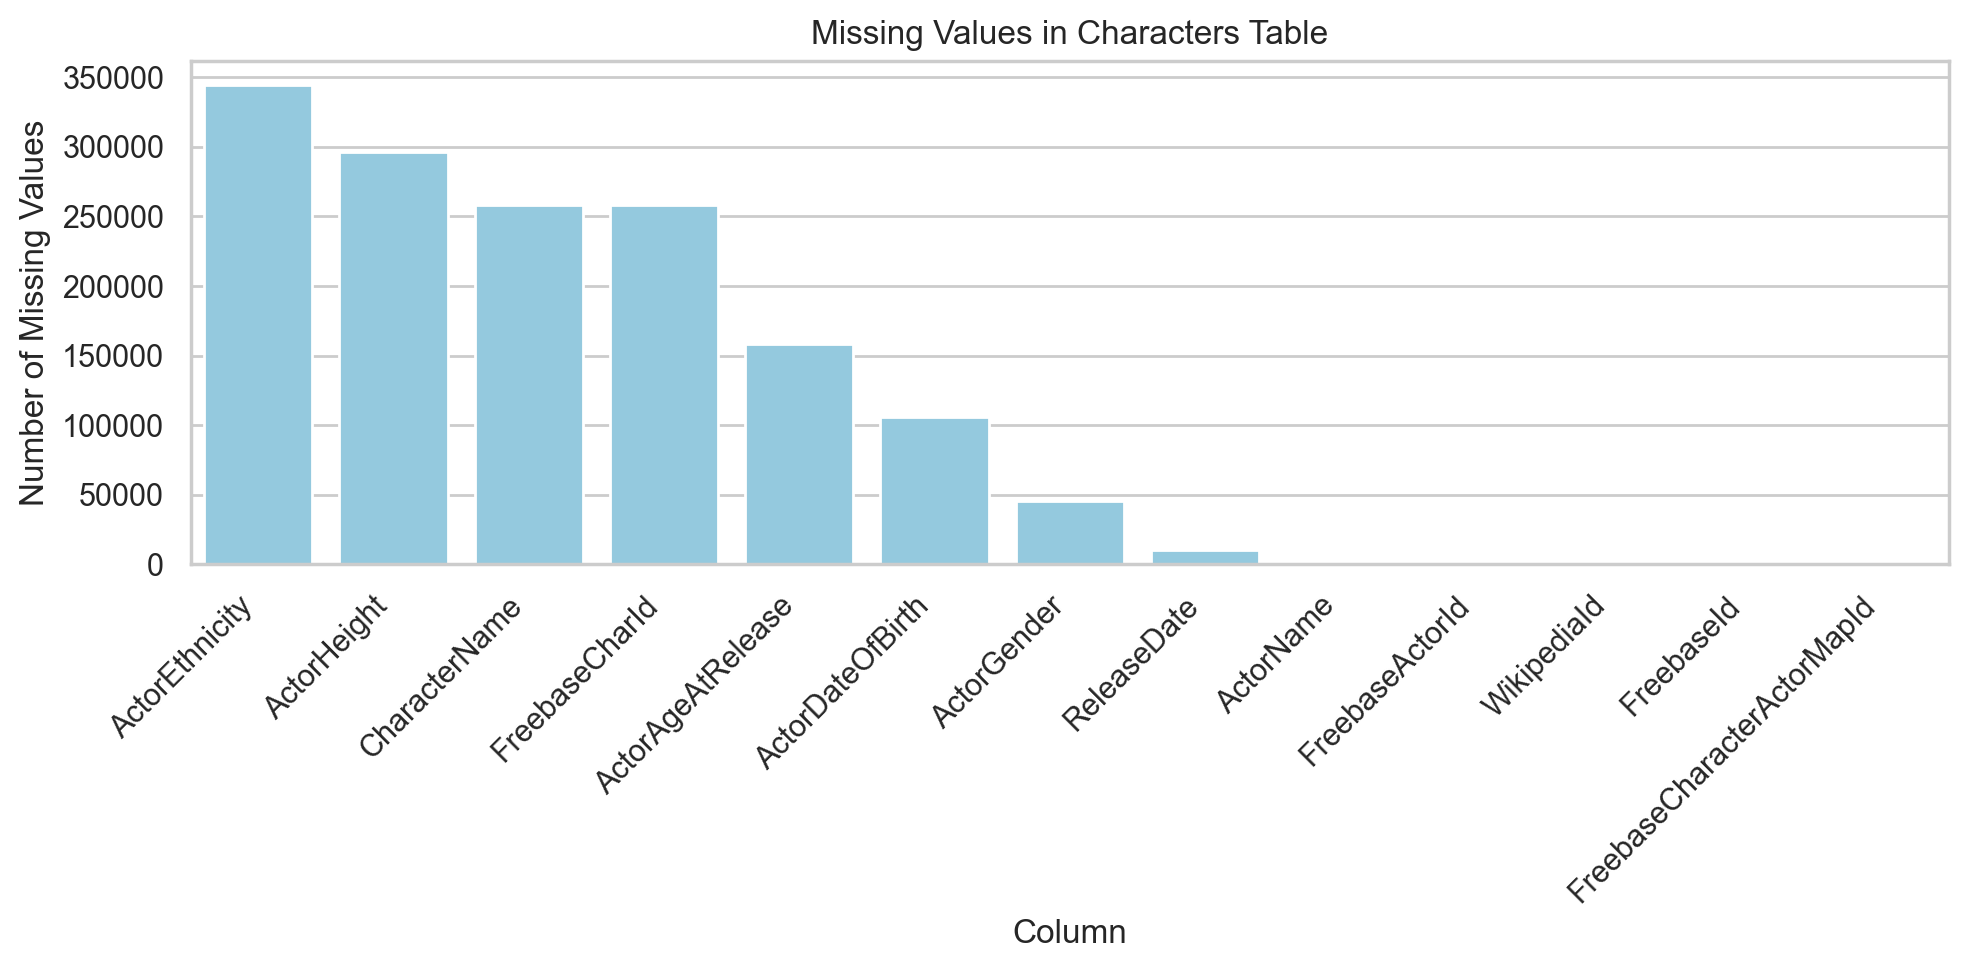

In [9]:
plot_nan_distribution(characters, table_name="Characters")

In [10]:
plot_nan_distribution(plots, table_name="Plots")

There is no Nans in Plots


We see that there are a lot of Nans, but, as described in the README, we want to focus on USA movies. We filter the dataset to get movies produced in the USA (i.e., has USA in the "Countries" column).

In [11]:
from src.utils.helpers import filter_by_country
us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])

filter_by_country(country=United States of America)
Number of US movies: 34408


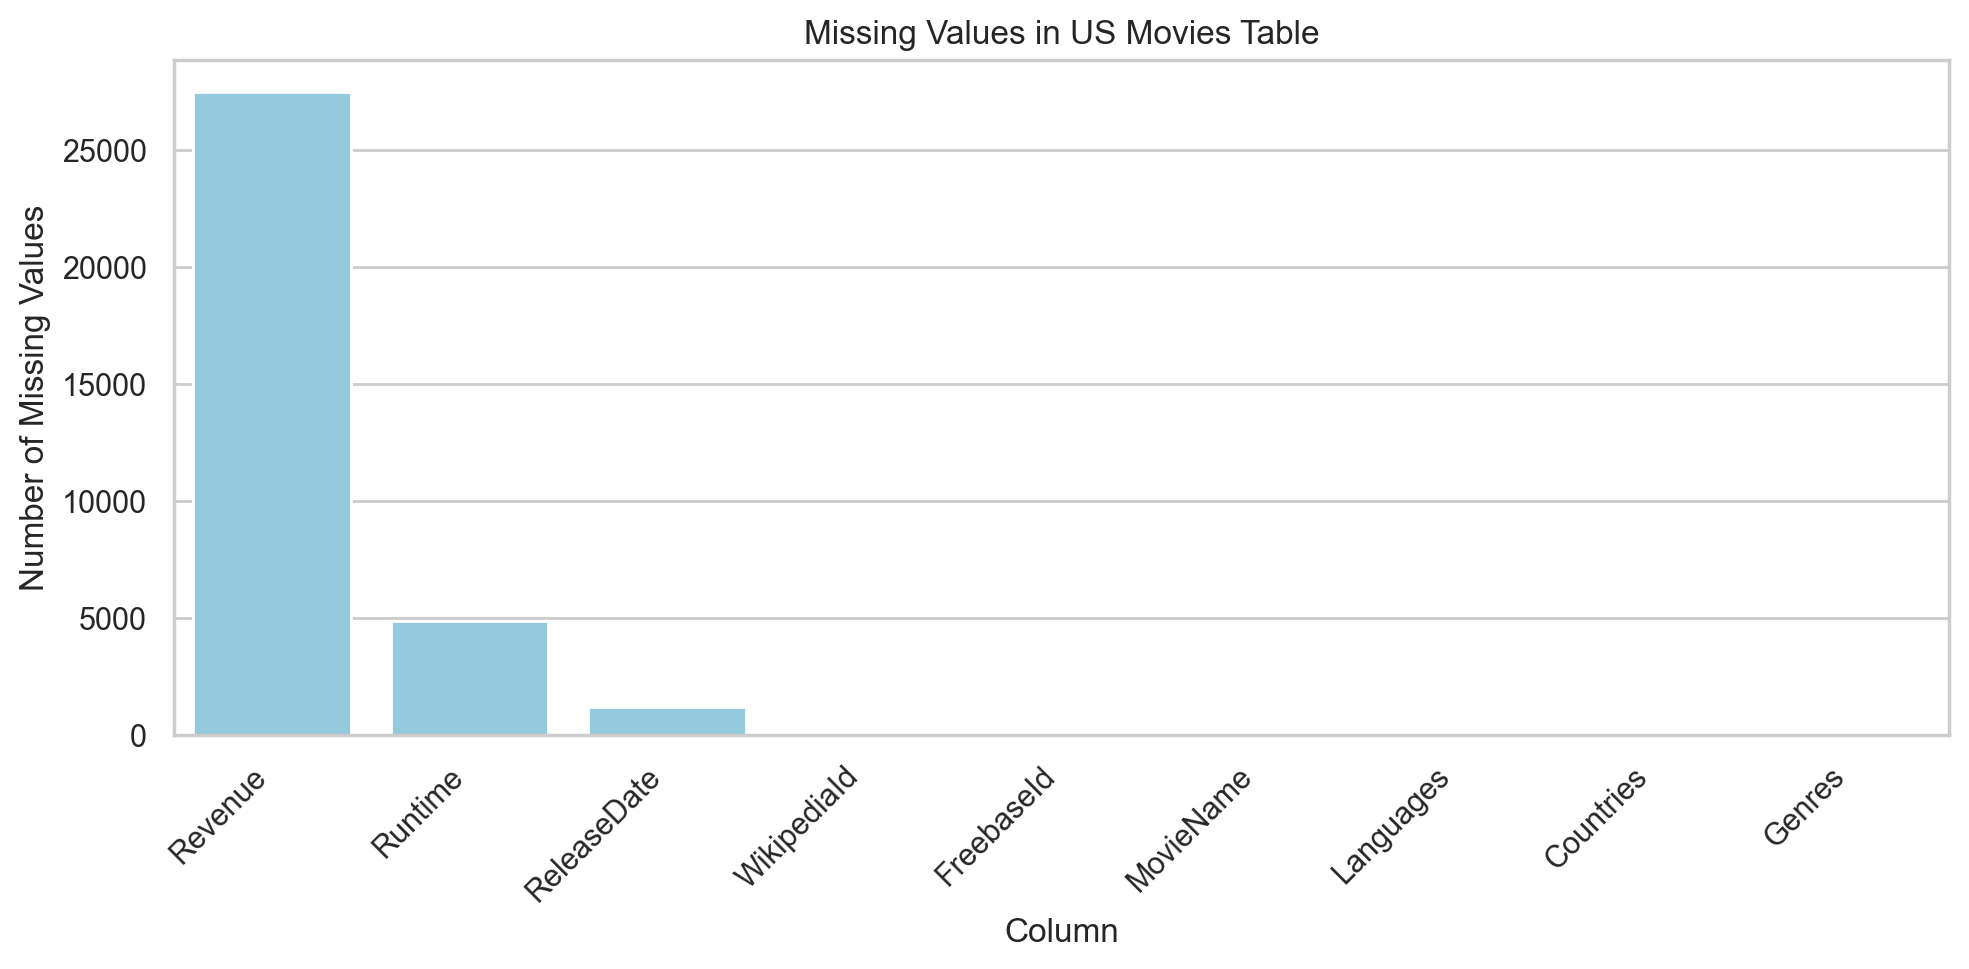

In [12]:
plot_nan_distribution(us_movies, table_name="US Movies")

As revenue is a core part of our analysis, we will drop the rows with missing revenue. We also want to investigate how clusters change in time, so we need the date information too and, therefore, keep only the non-Nan rows.

We also noticed that the ReleaseDate format is not fixed, so we change all values to a common format. 

In [13]:
from src.utils.helpers import drop_nans, fix_date

us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

drop_nans(column=Revenue)
drop_nans(column=ReleaseDate)
fix_date(column=ReleaseDate)
Number of US movies after dropping Nans: 6923


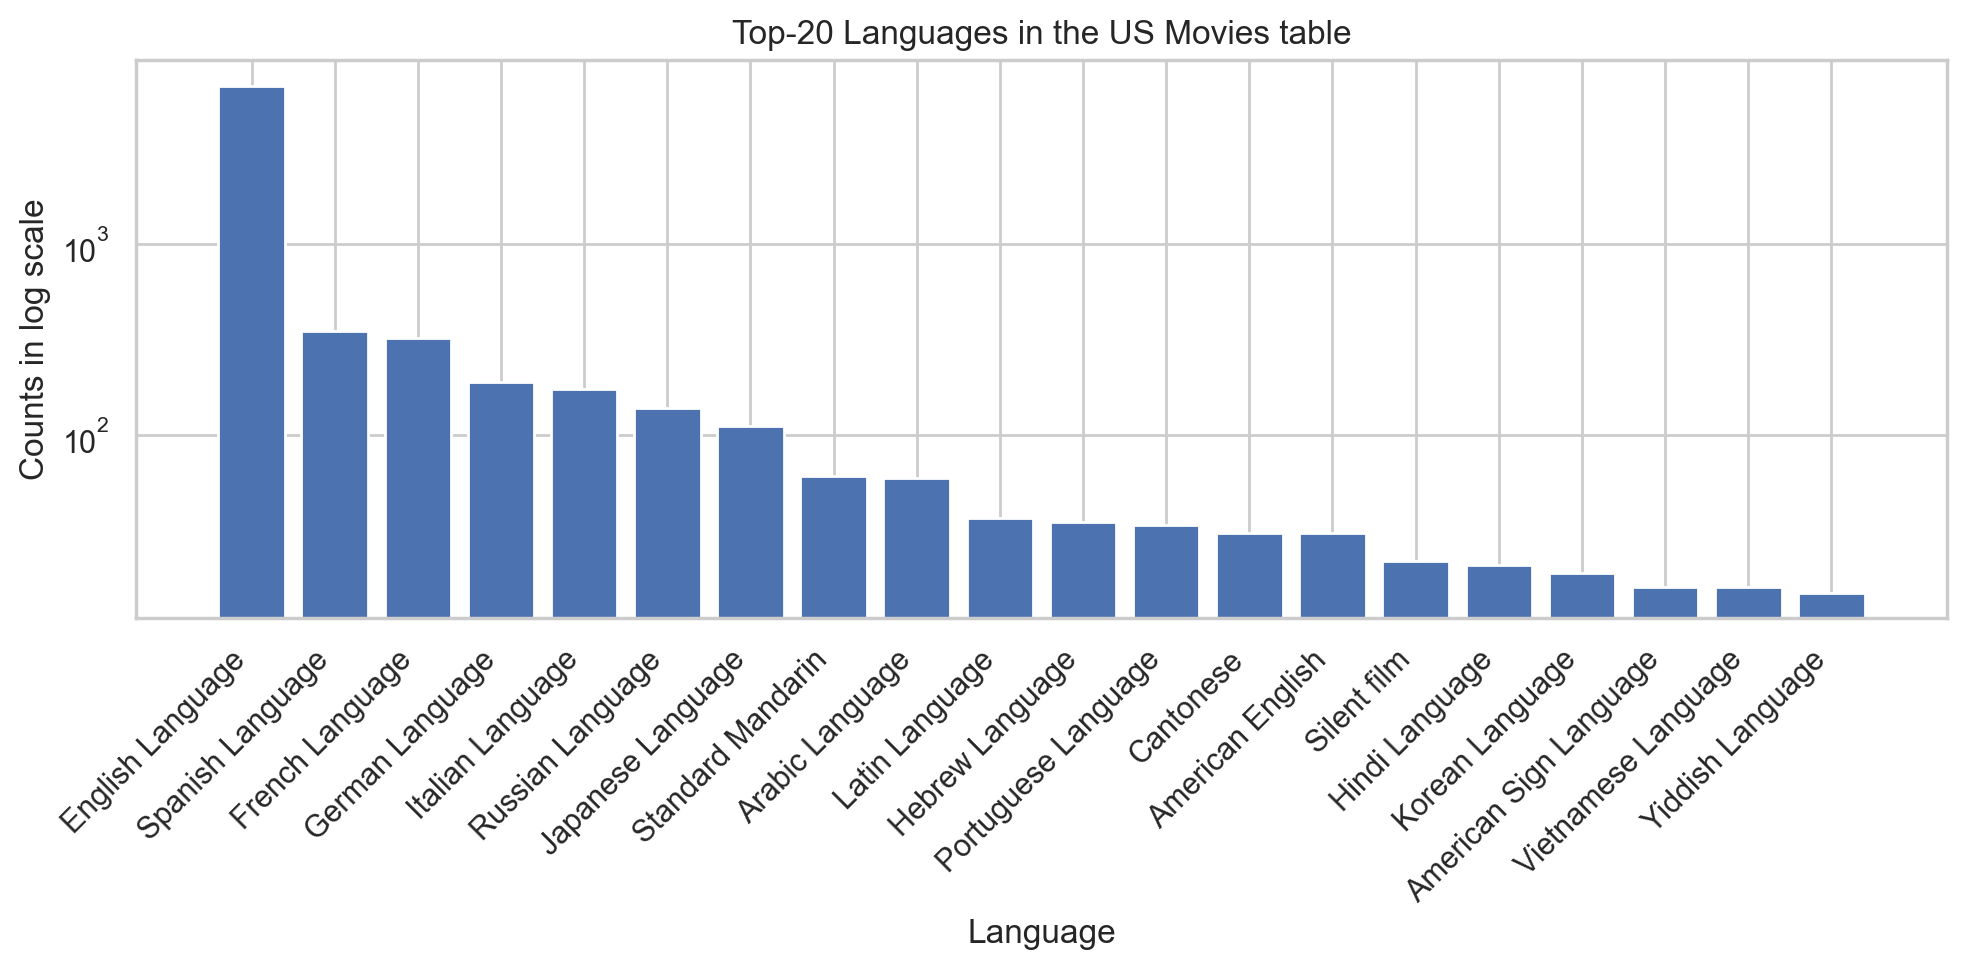

The top-1 language is in 97.91% of the movies


In [14]:
from src.utils.helpers import get_language_distribution
get_language_distribution(us_movies, table_name="US Movies", limit=20)

We see that English language is in $97.91\%$ of the movies. This, together with the plot, means that movies with other languages may be outliers for our analysis and bias the results. Thus, we remove movies that are not in English.

In [15]:
from src.utils.helpers import filter_by_language
us_movies = filter_by_language(us_movies, language="English Language")

filter_by_language(language=English Language)


Let's see the temporal distribution of our data after filtering.

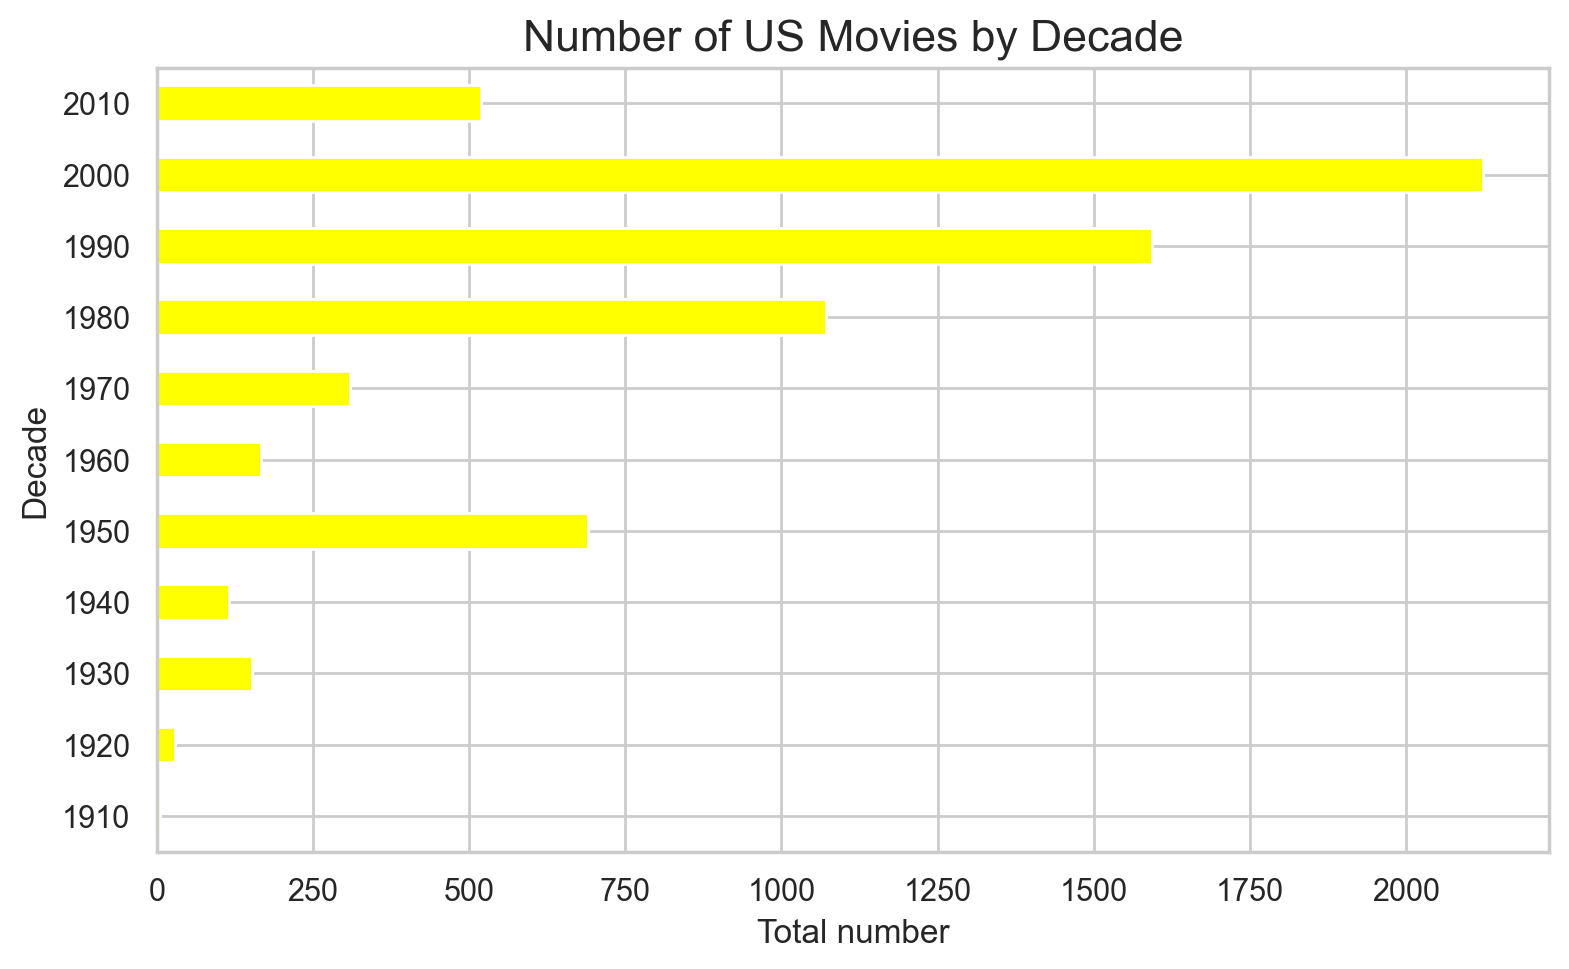

In [16]:
from src.utils.helpers import plot_decade_distribution
plot_decade_distribution(us_movies, table_name="US Movies")

Let's look at the revenue distribution:

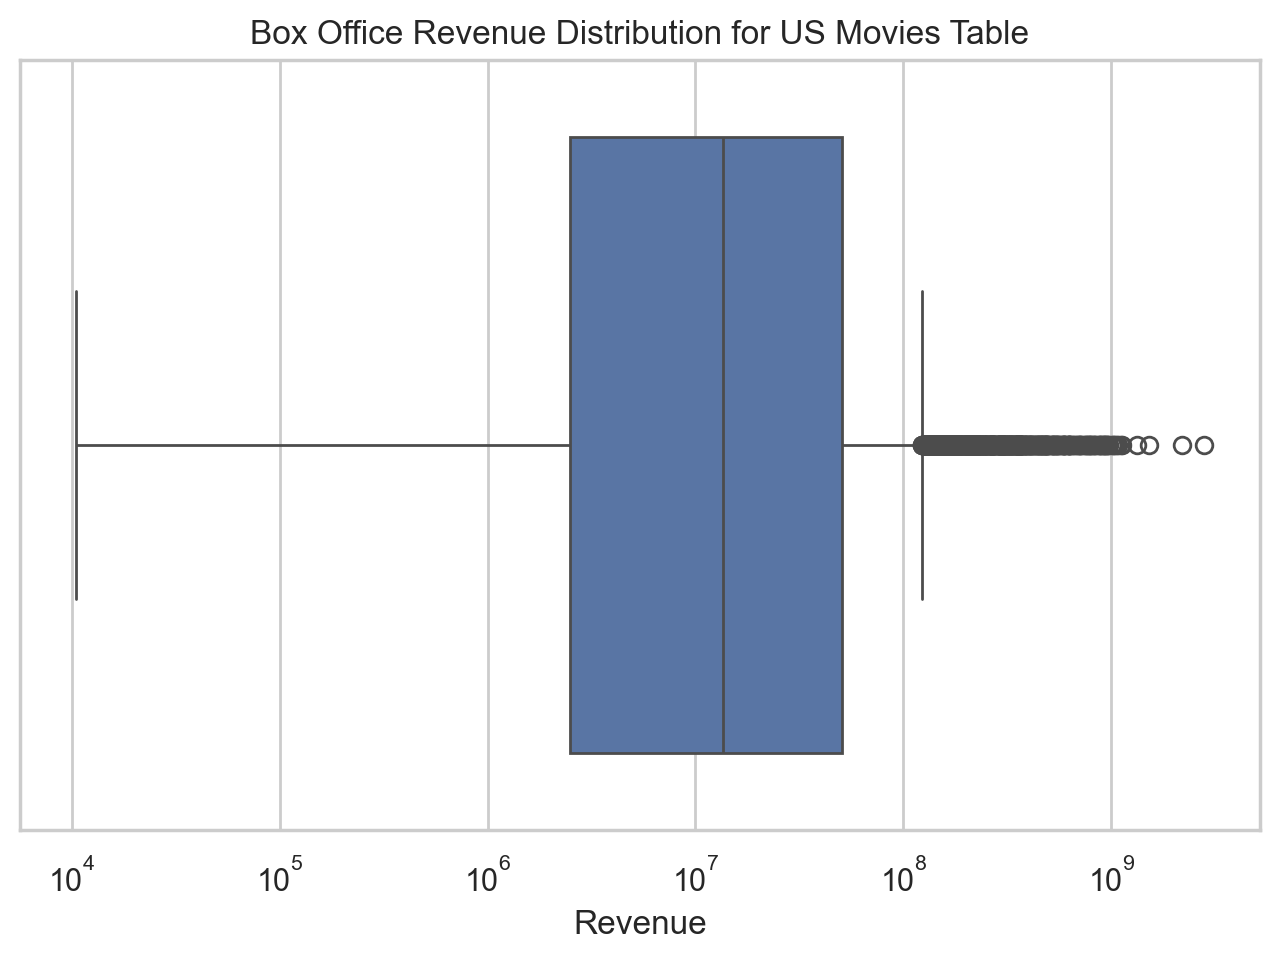

In [17]:
from src.utils.helpers import plot_revenue_distribution

plot_revenue_distribution(us_movies, table_name="US Movies")

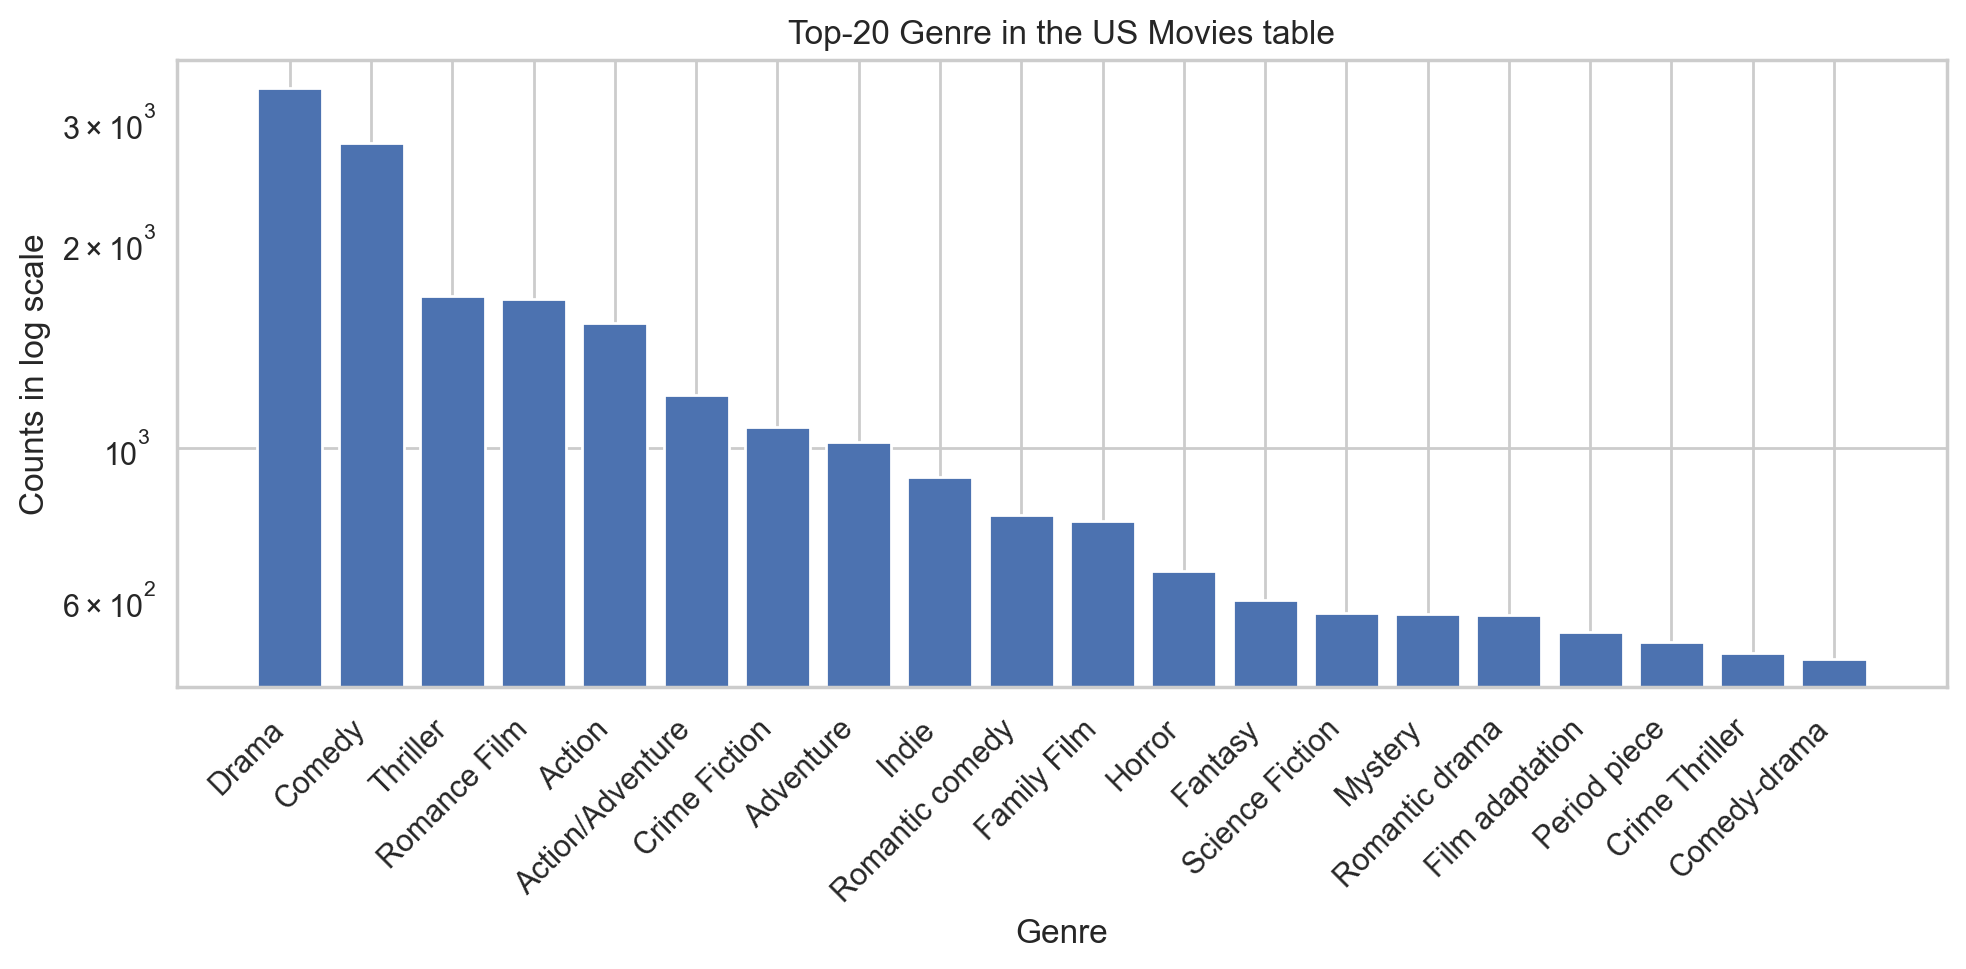

In [18]:
from src.utils.helpers import plot_top_genres

plot_top_genres(us_movies, table_name="US Movies", limit=20)

### Characters

Now, let's move to `characters` table (also referred as `actors`). We already saw that there are some Nans

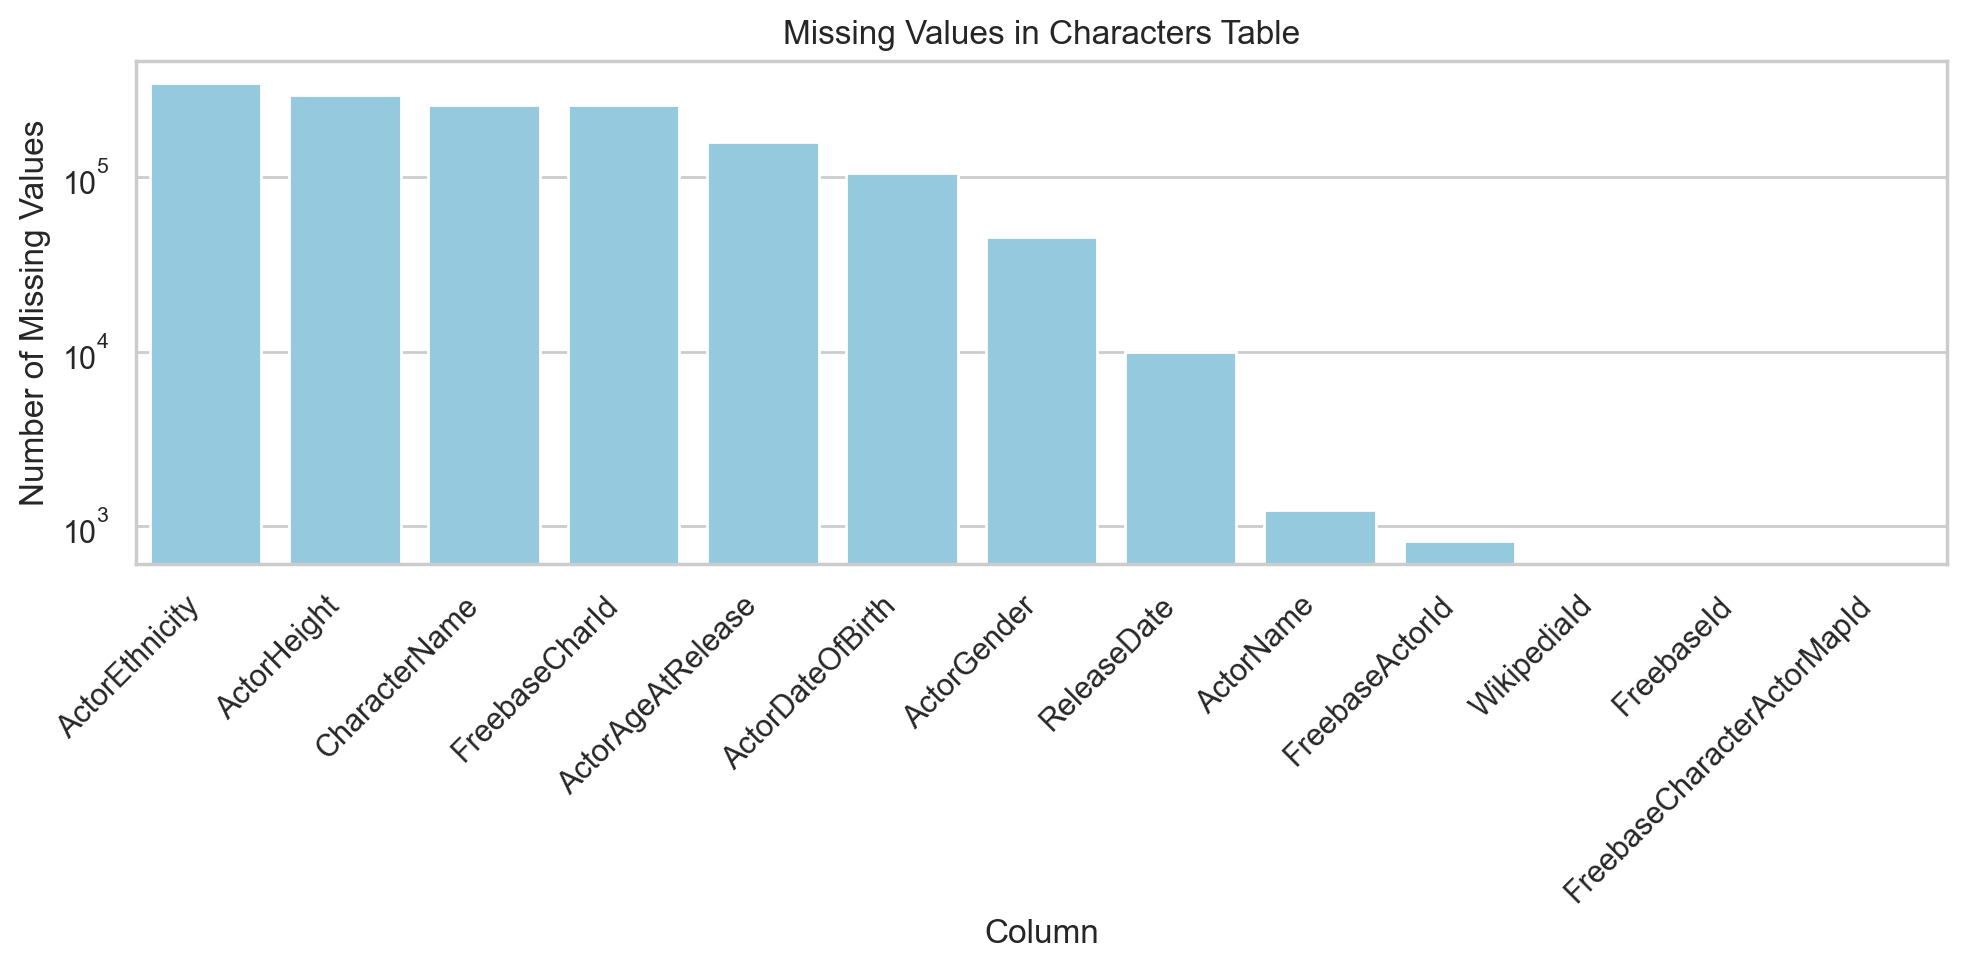

In [19]:
plot_nan_distribution(characters, table_name="Characters", log_scale=True)

This time we plotted it with a log-scale Y-axis and saw that actually some of the `FreebaseActorId` are Nan. We should drop such rows because we cannot create a graph without knowing actors. We are not touching other columns because we are not utilizing them in the current analysis.

In [20]:
characters = drop_nans(characters, column="FreebaseActorId")

drop_nans(column=FreebaseActorId)


Let's do some statistical analysis

In [21]:
from src.utils.actors import ActorStats

actor_stats = ActorStats(characters=characters, movies=us_movies)

At first, let's look at the statistics for a specific actor. For example, `/m/0c0k1` (Harrison Ford)

In [22]:
actor_id = "/m/0c0k1"
actor_stats.actor_name(actor_id)

'Harrison Ford'

In [23]:
actor_stats.actor_movies(actor_id).head(2)

,WikipediaId,FreebaseId,MovieName,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Year,Decade
1983,43307,/m/0bw20,K-19: The Widowmaker,2002-07-19,65716126.0,138.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio...",2002,2000
2637,365039,/m/01_wsl,Six Days Seven Nights,1998-06-12,164839294.0,102.0,"{""/m/04306rv"": ""German Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03k9fj"": ""...",1998,1990


In [24]:
actor_stats.actor_prefered_genres(actor_id, n=4)

[('Drama', 23), ('Action', 17), ('Thriller', 15), ('Action/Adventure', 12)]

In [25]:
actor_stats.print_actor_stats(actor_id)

Name: Harrison Ford
  * Played in 35 movies.
  * Favourite genre: Drama (23 movies).
  * Total movie revenues:    6,397,871,819$.
  * Average movie revenue:     182,796,338$.


Our primary goal is to analyze clusters as described in the README. But before going into the cluster analysis, let's look at the whole picture by assigning all actors (participated in the `us_movies`) to a single cluster. This allows us to use the same functions without copy-pasting the code.

In [26]:
from src.utils.helpers import merge_movies_and_actors

us_characters_movies = merge_movies_and_actors(us_movies, characters)
# note that there might be movies without actors information
print("Total number of movies after merge:", us_characters_movies.groupby("WikipediaId").size().shape[0])

Total number of movies after merge: 6693


In [27]:
us_actors = us_characters_movies.FreebaseActorId.unique()
print("Total number of actors in the US movies:", us_actors.shape[0])

Total number of actors in the US movies: 30378


In [28]:
# create a single cluster of all us actors for the full analysis
from src.utils.actors import Cluster

full_cluster = Cluster(characters=characters, movies=us_movies, actor_ids=us_actors)

In [29]:
full_cluster.cluster_mean_revenue()

67705066.10700375

In [30]:
full_cluster.cluster_total_revenue()

374115470742.0

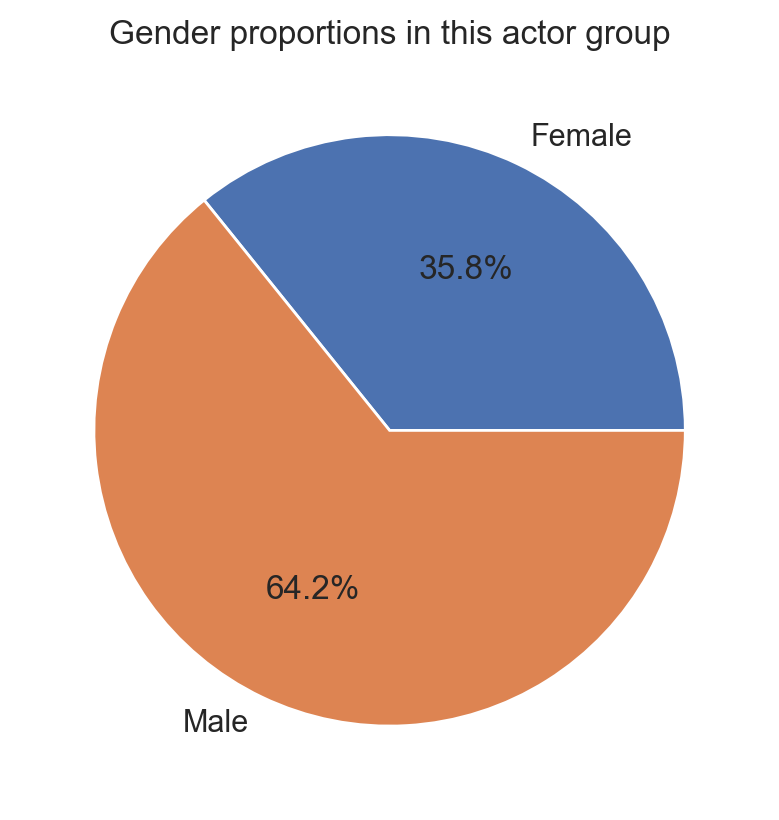

In [31]:
_ = full_cluster.cluster_genders(plot=True)

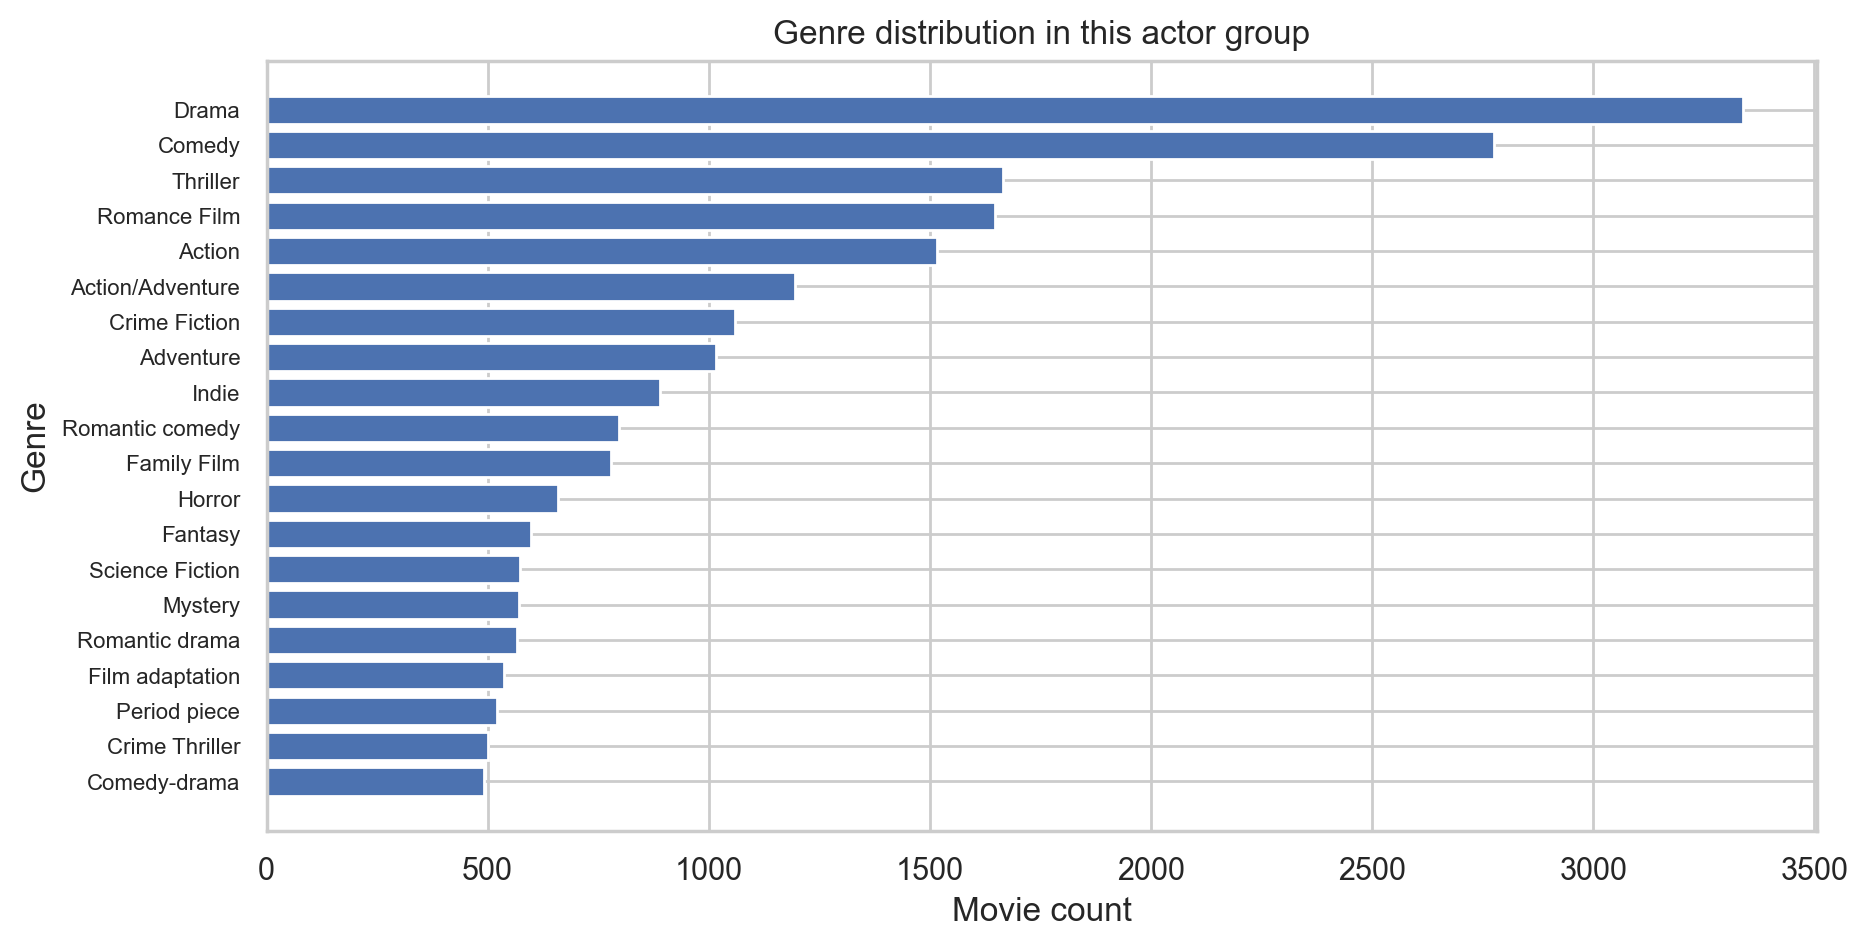

In [32]:
_ = full_cluster.cluster_genres(plot=True)

# Partitioning 

In this section, we define the "friendship" graph: actors are used as vertices and two actors are "friends" (i.e., have an edge connecting them) if they have a mutual movie.

In [33]:
import networkx as nx
from src.utils.helpers import create_graph_from_data

G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

Number of vertices: 30378, number of edges: 613672


In [34]:
from src.utils.helpers import get_connected_components
connected_component_sizes = sorted(map(len, get_connected_components(G_US)), reverse=True)
print(f"Number of components: {len(connected_component_sizes)}, sizes of top-5 components: {connected_component_sizes[:5]} ")

Number of components: 70, sizes of top-5 components: [30005, 18, 18, 17, 16] 


In [35]:
30005 / 30378 * 100

98.77213773125288

We see that we cannot use connected components as meaningful clusters because $\frac{30005}{30378} \cdot 100\% \simeq 98.8\%$ of the actors are in one of them, while other components have less than $0.06\%$ each. So we use [Louvain Community Detection algorithm](https://github.com/taynaud/python-louvain), described in the README.

In [36]:
from src.utils.helpers import get_communities
set_random_seed() # to enhance reproducibility

In [ ]:
from src.utils.helpers import get_communities
set_random_seed() # to enhance reproducibility

communities_US = get_communities(G_US) # takes some time

In [ ]:
### we commented this cell because we saved the communities into a json

# from src.utils.helpers import read_json, write_json
# from src.data import ROOT_PATH

# # to enhance reproducibility **between** machines, we save communities and push them on Git
# processed_dir = ROOT_PATH / "data" / "processed"
# processed_dir.mkdir(exist_ok=True, parents=True)

# write_json(communities_US, fname=str(processed_dir / "communities_US.json"))

### Communities in the new format

In [37]:
### we commented this cell because we saved the communities into a json

from src.utils.helpers import read_communities, write_communities
from src.data import ROOT_PATH

for communities_seed in range(1, 6):
    # to enhance reproducibility **between** machines, we save communities and push them on Git
    processed_dir = ROOT_PATH / "data" / "processed"
    processed_dir.mkdir(exist_ok=True, parents=True)

    communities_US = get_communities(G_US, seed=communities_seed) # takes some time

    write_communities(G_US, communities_US, fname=str(processed_dir / f"new_communities_US_{communities_seed}.json"))

#### Communitites when filtering by non-NaN ActorName as well

In [38]:
from src.utils.helpers import drop_nans_subset

characters_with_actorname = load_characters()
characters_with_actorname = drop_nans_subset(characters_with_actorname, subset=["ActorName", "FreebaseActorId"])
us_characters_movies_with_actorname = merge_movies_and_actors(us_movies, characters_with_actorname)
G_US_with_actorname = create_graph_from_data(us_characters_movies_with_actorname)
communities_US_with_actorname = get_communities(G_US_with_actorname) # takes some time

processed_dir = ROOT_PATH / "data" / "processed"
processed_dir.mkdir(exist_ok=True, parents=True)

write_communities(G_US_with_actorname, communities_US_with_actorname, fname=str(processed_dir / "new_communities_US_with_actorname.json"))


drop_nans_subset(subset=['ActorName', 'FreebaseActorId'])


In [39]:
characters.shape, characters_with_actorname.shape

((449854, 13), (449441, 13))

In [40]:
communities_US = read_communities(G_US, str(processed_dir / "new_communities_US_1.json"))

In [41]:
community_sizes = sorted(map(len, communities_US), reverse=True)
print(f"Number of communities: {len(communities_US)}, sizes of top-5 communities: {community_sizes[:5]} ")

Number of communities: 133, sizes of top-5 communities: [6332, 5748, 4505, 3979, 1655] 


TODO add plot

## Verification of clusters quality

To ensure that our partitioning is reasonable, we conduct some sanity check experiments. In this one, we assign a cluster for each movie: if more than $50\%$ of the movie actors are inside cluster `SomeName`, we assign this cluster `SomeName` to the movie. Note that some movies may not have any cluster assigned after this operation (if, for example, its actors are evenly spread across more than 2 clusters).

Then, for each cluster, we investigate the distribution of the release year for its movies (movies assigned to this cluster). We assume that a good clustering algorithm should combine actors that participated in the movies of roughly the same time period. This is reasonable as actors become old and is unlikely that the actor who played in the 1940's will also appear in 2010's movies, for example. Or, for instance, Stallone, Schwarzenegger, and Lundgren are well-known actors of old-school action-movies and it would be reasonable for them to be in one cluster. While, for instance, The Rock, Hardy, and Gosling are more modern acion-movies actors and probably should be in another cluster. This said, we assume the calculated distribution of movies actors to be compact.

In [42]:
from src.utils.helpers import calculate_partition_quality

df_parition_top_movie_info = calculate_partition_quality(G=G_US, communities=communities_US,
                                                         movies=us_movies,
                                                         characters_movies=us_characters_movies,
                                                         take_film_fraction=0.5)

The performance (partition quality) metric is 0.876074229844255
The coverage (partition quality) metric is 0.6190342723800336


We also calculated the `networkx` partition quality metrics $\in [0,1]$. The "coverage" metric measures the ratio of number of the edges that are inside partitions to the total number of edges. If this number is close to 1, it means that the algorithm works like "connected component" approach, which is bad (when you have extremely large components), as we discussed above. If this number is close to 0, it means that the clusters are extremely small, which hurts the analysis and conclusions. For our choice of the algorithm, the metric is good. The "performance" metrics calculates the ratio of the sum of the number of edges inside the clusters and the number of non-edges (if two vertices do not have an edge, we say this is a non-edge) between the clusters to the total number of possible edges ($\frac{n(n-1)}{2}$ for the graph with $n$ vertices). See more in [this paper](https://arxiv.org/abs/0906.0612).

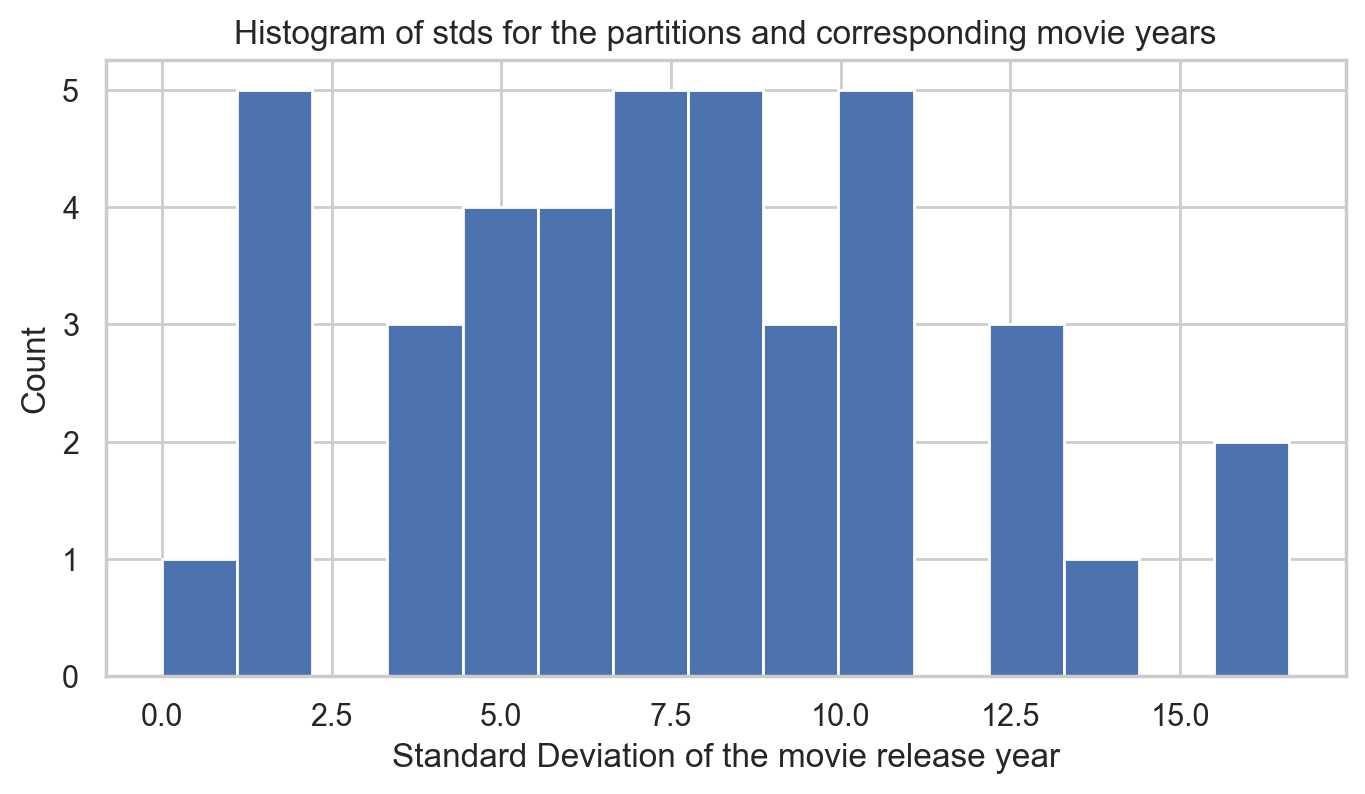

In [43]:
from src.utils.helpers import plot_partition_year_std_distribution

plot_partition_year_std_distribution(df_parition_top_movie_info)

We see that mostly the std is around $8$ years which sounds reasonable enough, given that we have a long time range of movies in the dataset (from 1910s to 2010s, i.e. a range of 100 years)

Now, we will work with our Graph wrapper for stats calculation

In [44]:
from src.utils.graphs import Graph

graph_stats = Graph.init_from_list_of_lists(characters=characters,
                                            movies=us_movies,
                                            communities=communities_US)

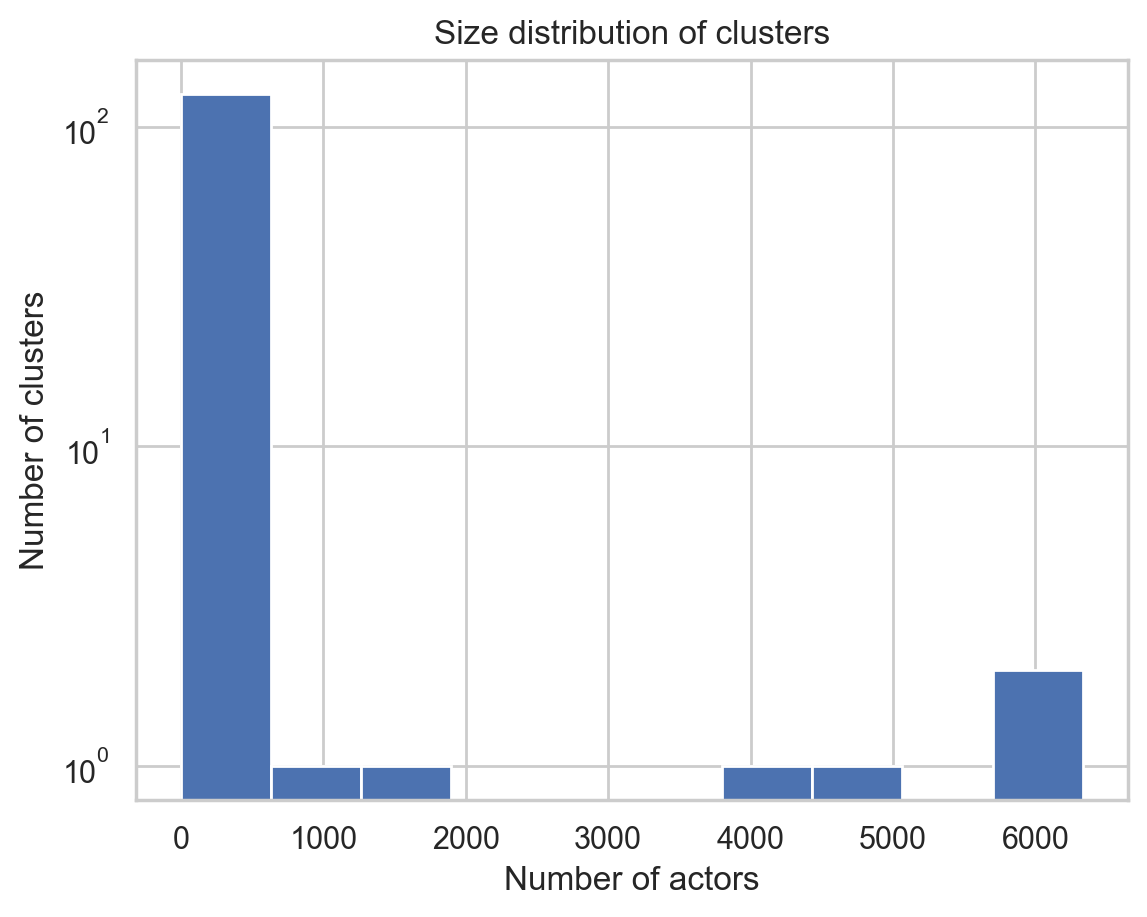

In [45]:
_ = graph_stats.size_distribution(plot=True, log=True)

As we also saw previously, the top-5 clusters contain more than $1000$ actors. This is also clear in this plot. To see better see the distribution of smaller clusters, we remove the clusters with more than $1000$ actors from the plot

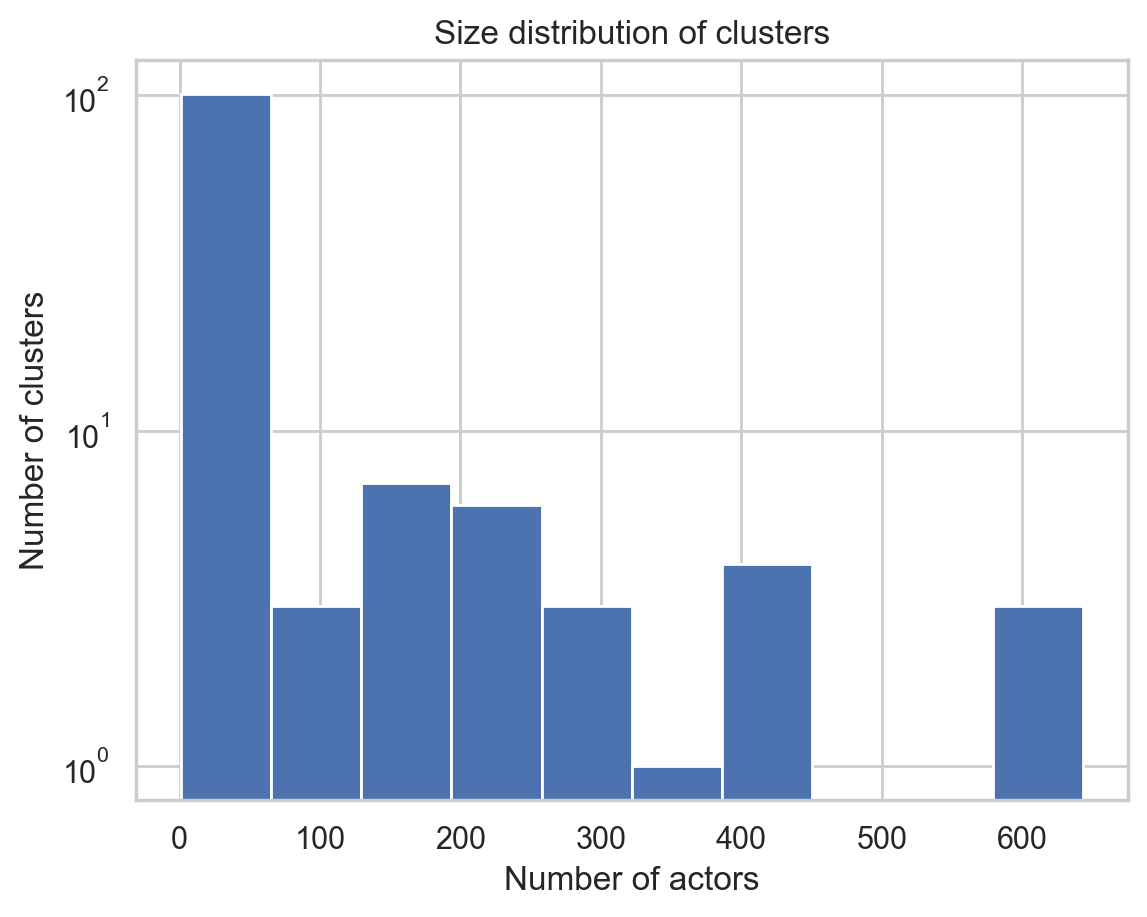

In [46]:
_ = graph_stats.size_distribution(plot=True, log=True, max_value=1000)

Here are some statistics about the distribution of our clusters:

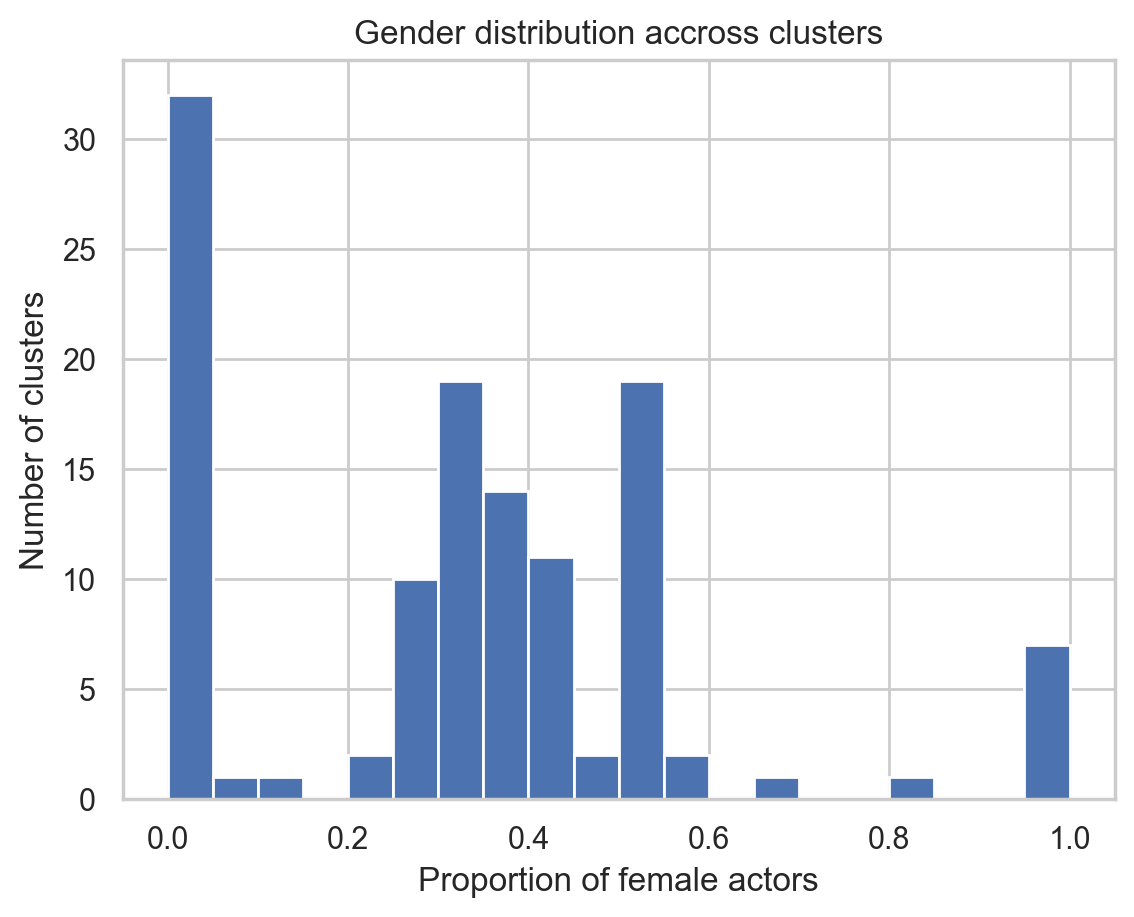

In [47]:
_ = graph_stats.gender_distribution(plot=True)

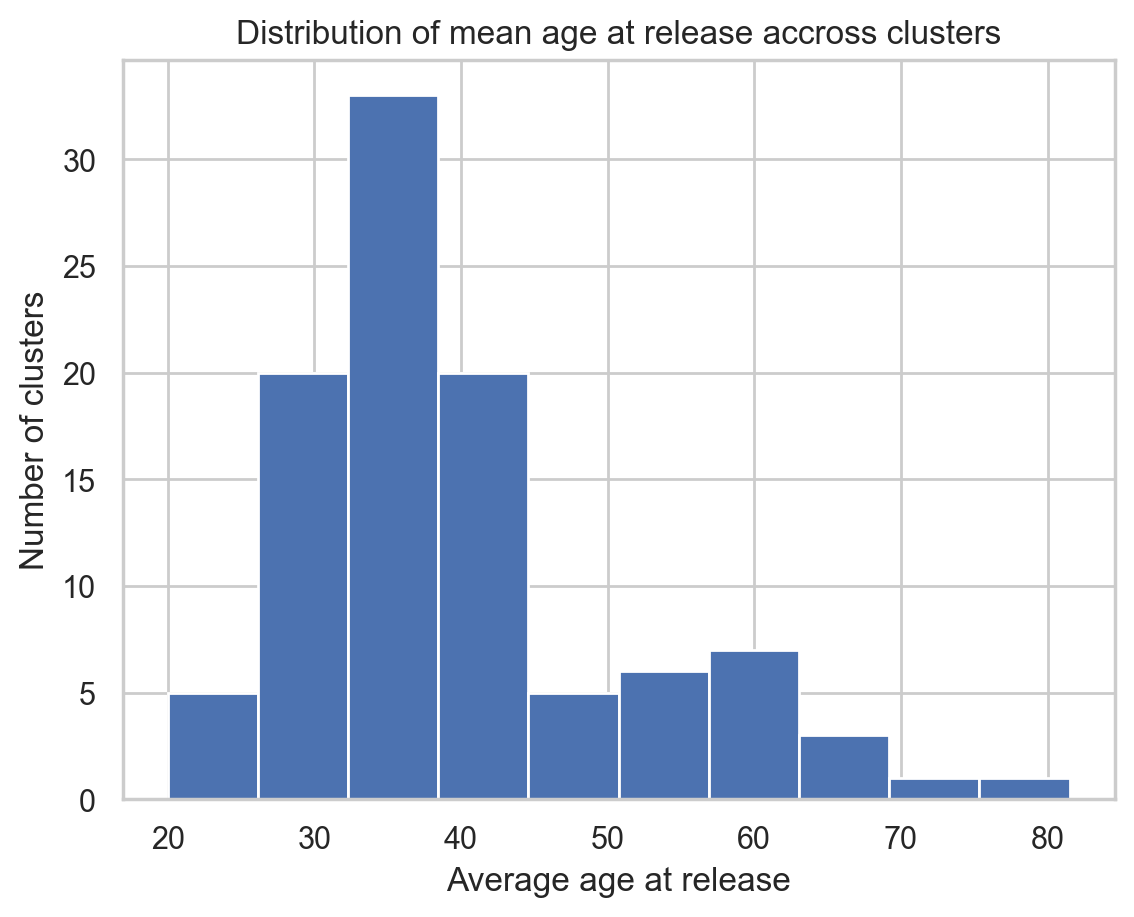

In [48]:
_ = graph_stats.age_distribution(plot=True)

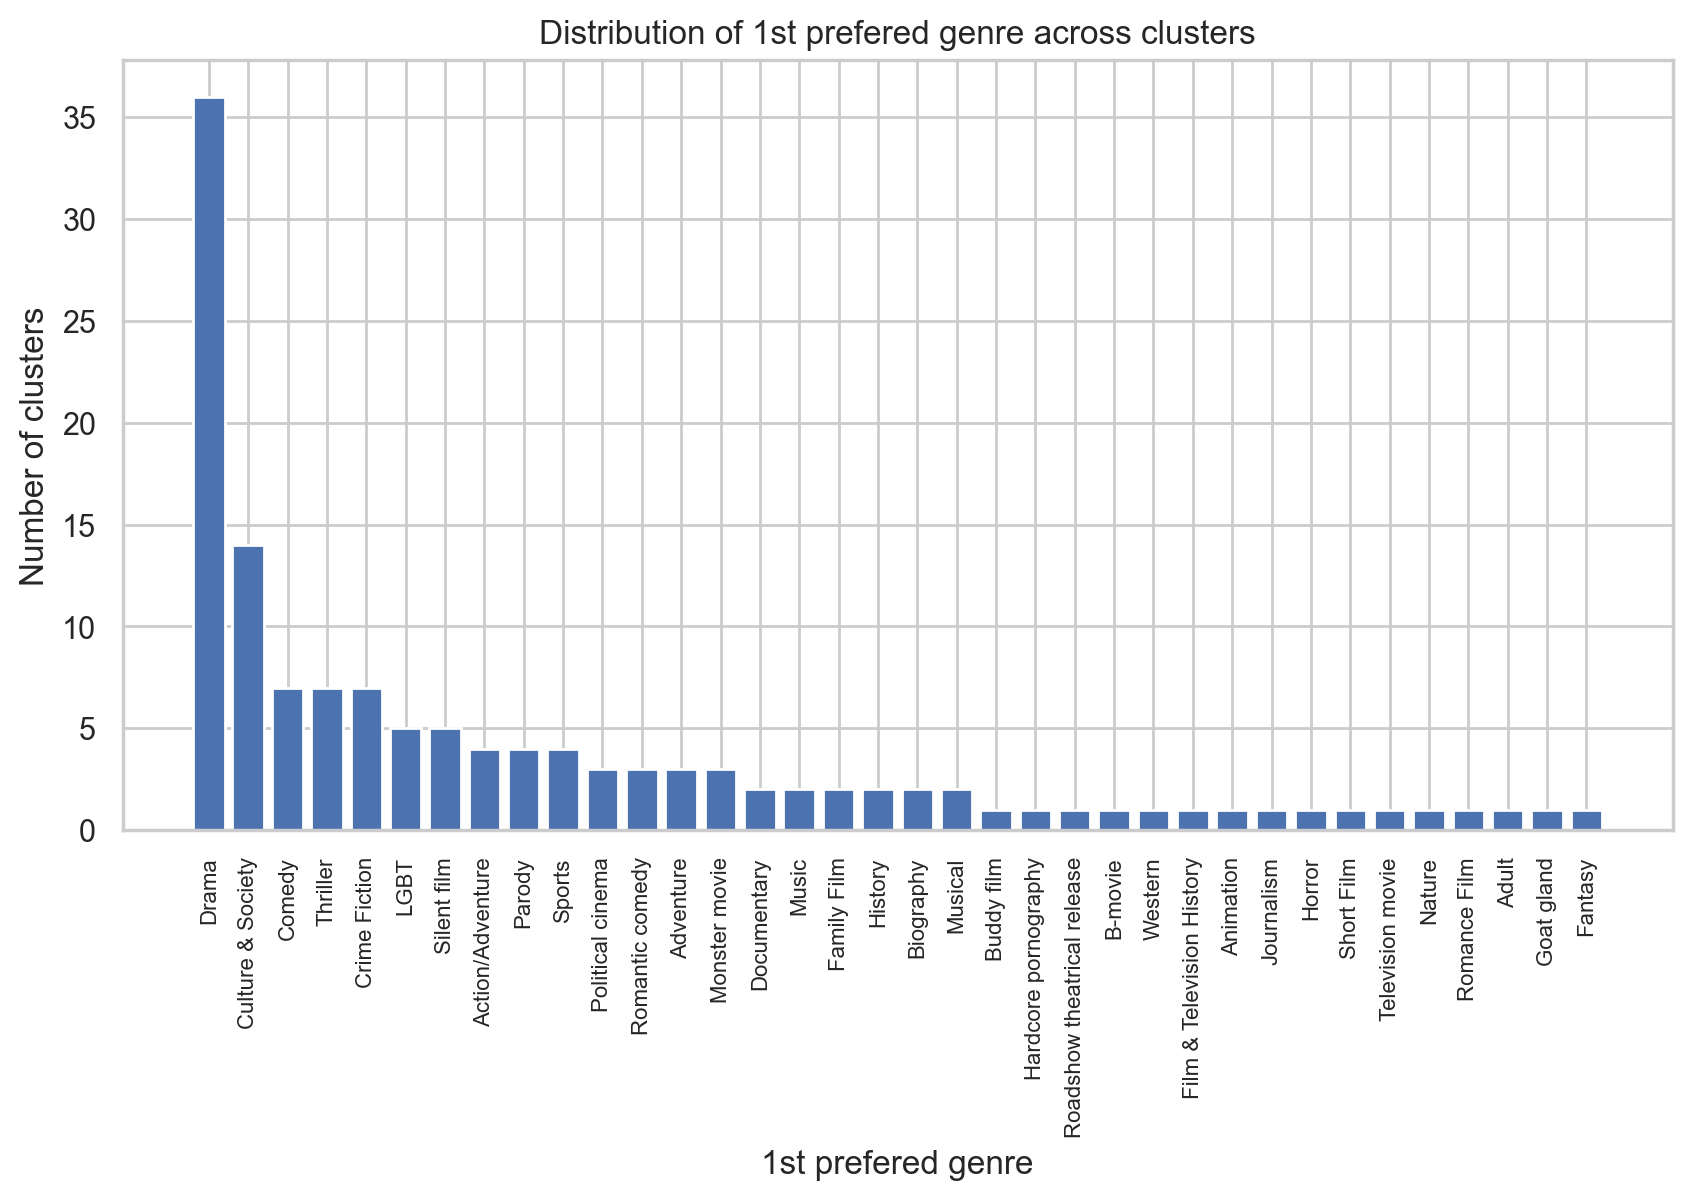

In [49]:
_ = graph_stats.nth_genre_distribution(1, plot=True)

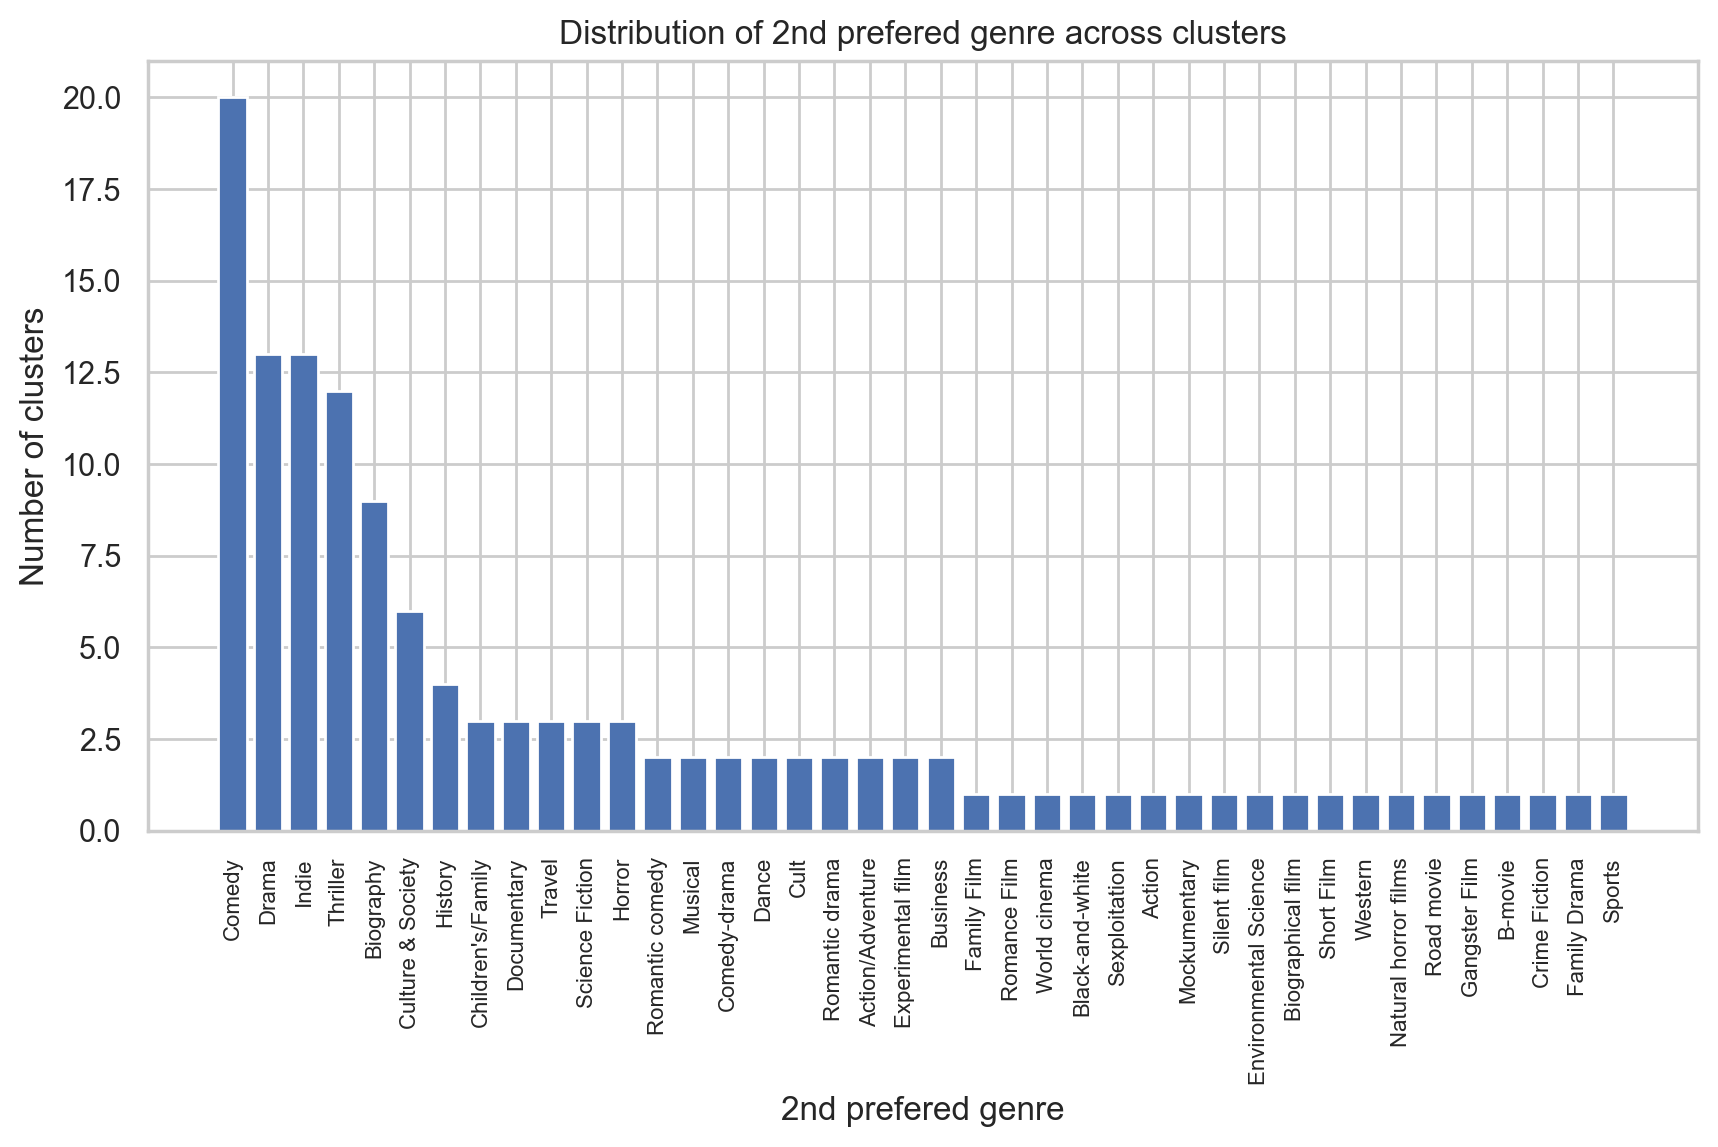

In [50]:
_ = graph_stats.nth_genre_distribution(2, plot=True)

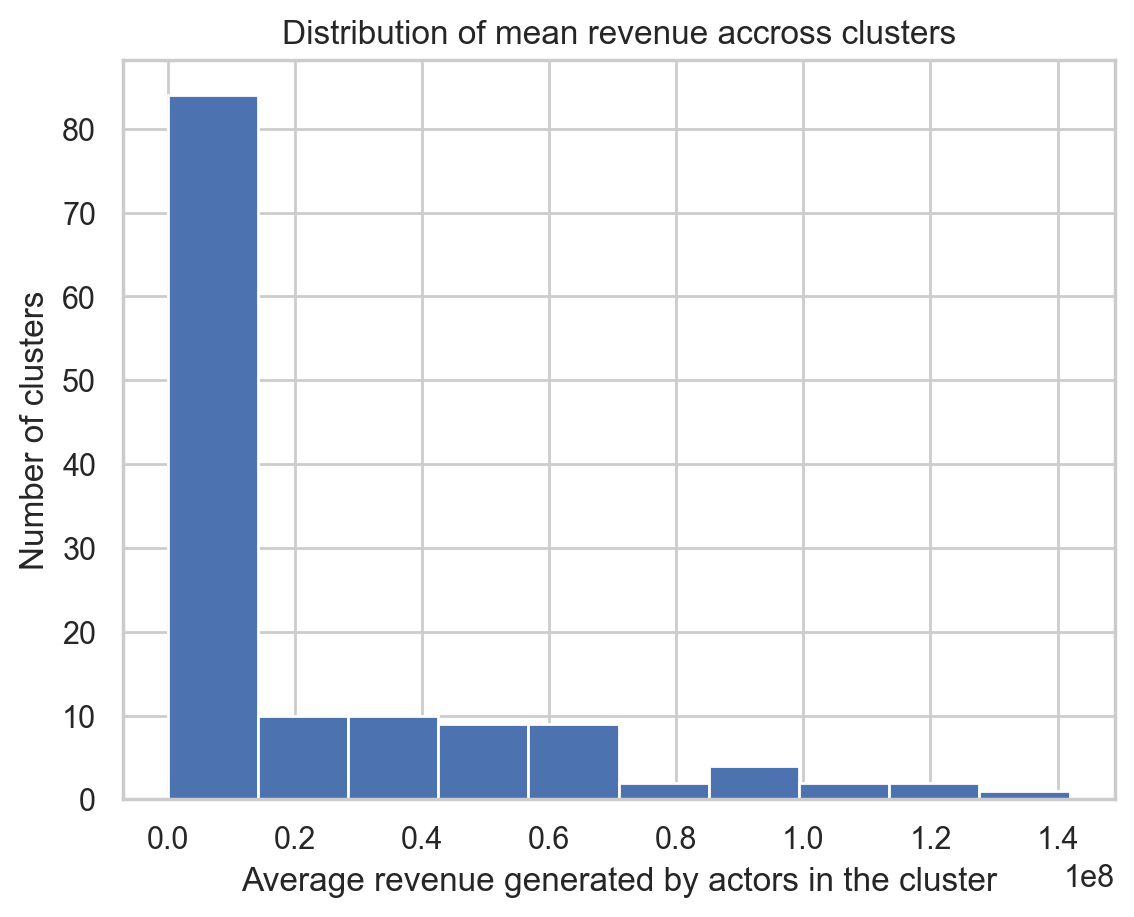

In [51]:
_ = graph_stats.revenue_distribution(plot=True)